In [1]:
!pip install tensorflow keras scikit-learn opencv-python matplotlib numpy pandas
!pip install keras-tuner


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc




In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set up directories for the dataset
base_dir = r'C:\Users\ACER\Mpox\monkeypox_data'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Define image size and batch size for training and validation
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Setting up ImageDataGenerators for training and validation with enhanced augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.2,  
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,  
    horizontal_flip=True, 
    fill_mode='nearest'
)


valid_datagen = ImageDataGenerator(rescale=1./255)  

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),  
    batch_size=BATCH_SIZE,               
    class_mode='categorical',             
    shuffle=True                         
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),  
    batch_size=BATCH_SIZE,                
    class_mode='categorical',             
    shuffle=False                         
)

# Print number of batches and classes in each dataset
print(f'Train generator: {train_generator.samples} samples')
print(f'Validation generator: {valid_generator.samples} samples')
print(f'Classes: {train_generator.class_indices}')


Found 228 images belonging to 2 classes.
Found 228 images belonging to 2 classes.
Train generator: 228 samples
Validation generator: 228 samples
Classes: {'Monkeypox': 0, 'No_Monkeypox': 1}


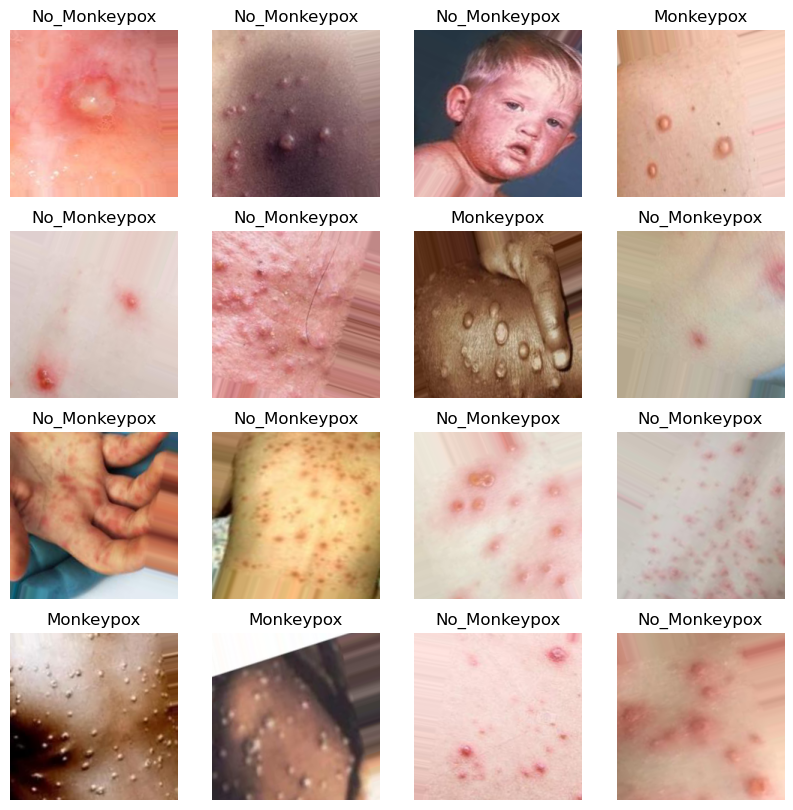

In [7]:


# Function to display images from the generator
def display_images(generator, num_images=16):
    # Get one batch of images and labels from the generator
    image_batch, label_batch = next(generator)
    
    # Get the class names from the generator
    class_names = list(generator.class_indices.keys())
    
    # Create a plot with subplots
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i])
        plt.title(class_names[np.argmax(label_batch[i])])  # Display class label
        plt.axis("off")
    plt.show()

# Display 16 images from the training set
display_images(train_generator, num_images=16)

        

In [9]:
#CNN

In [111]:
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Define the model building function
def create_cnn_model(hp):
    model = models.Sequential()

    # Define the first convolutional block
    model.add(layers.Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), 
                            (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Define second convolutional block
    model.add(layers.Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64), 
                            (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layers with hyperparameters for units and dropout
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)))
    model.add(layers.Dense(2, activation='softmax'))

    # Compile the model with a learning rate hyperparameter
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner and perform search
tuner_cnn = kt.Hyperband(create_cnn_model, 
                         objective='val_accuracy', 
                         max_epochs=10, 
                         hyperband_iterations=2, 
                         directory='cnn_tuner', 
                         project_name='monkeypox_cnn_tuning')

tuner_cnn.search(train_generator, validation_data=valid_generator, epochs=10)


Reloading Tuner from cnn_tuner\monkeypox_cnn_tuning\tuner0.json


In [112]:

# Retrain CNN model with the best hyperparameters
best_cnn_hp = tuner_cnn.oracle.get_best_trials()[0].hyperparameters
print("Best CNN Hyperparameters: ", best_cnn_hp.values)

# Create and train the model with the best hyperparameters
final_cnn_model = create_cnn_model(best_cnn_hp)
final_cnn_history = final_cnn_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20
)  # Store the history returned by model.fit()


Best CNN Hyperparameters:  {'filters_1': 128, 'filters_2': 64, 'dense_units': 192, 'dropout_rate': 0.2, 'learning_rate': 1.1697013417309728e-05, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 396s 44s/step - accuracy: 0.5178 - loss: 0.7377 - val_accuracy: 0.4518 - val_loss: 0.6960
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 191s 17s/step - accuracy: 0.5772 - loss: 0.6999 - val_accuracy: 0.3860 - val_loss: 0.6949
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.5567 - loss: 0.7151 - val_accuracy: 0.4342 - val_loss: 0.6936
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 65s 8s/step - accuracy: 0.5604 - loss: 0.7065 - val_accuracy: 0.5702 - val_loss: 0.6923
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.5843 - loss: 0.6814 - val_accuracy: 0.5395 - val_loss: 0.6918
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 159s 21s/step - accuracy: 0.6366 - loss: 0.6298 - val_accuracy: 0.5482 - val_loss: 0.6921
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 377s 48s/step - accuracy: 0.6032 - loss: 0.6564 - val_accuracy: 0.5482 - val_loss: 0.6927
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 332s 30s/step - accuracy: 0.6765 - loss: 0.6474 - val_accuracy: 0.5526 - val_loss: 0.69

In [115]:
# Display the summary of the CNN model
final_cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,264 (1.04 MB)

 Trainable params: 90,626 (354.01 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 181,254 (708.03 KB)

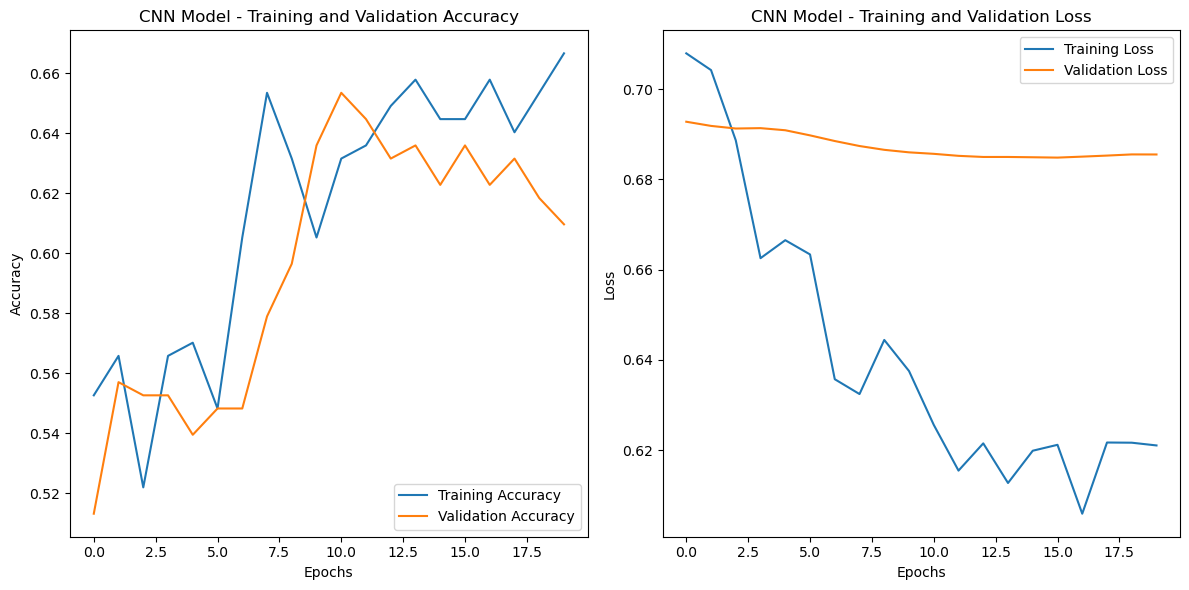

In [17]:

# Visualization of Training and Validation Accuracy & Loss
def plot_training_history(history):
    """
    Function to plot training and validation accuracy & loss
    """
    plt.figure(figsize=(12, 6))

    # Access the history attribute
    training_history = history.history

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(training_history['accuracy'], label='Training Accuracy')
    plt.plot(training_history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('CNN Model - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history['loss'], label='Training Loss')
    plt.plot(training_history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('CNN Model - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(final_cnn_history)


In [19]:
#Resnet

In [21]:
from tensorflow.keras.applications import ResNet50
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

def create_resnet_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Freeze or unfreeze layers based on hyperparameters
    for layer in base_model.layers[:hp.Int('freeze_layers', min_value=50, max_value=150, step=50)]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)),
        layers.Dense(2, activation='softmax')
    ])

    # Compile the model with a learning rate hyperparameter
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner and perform search for ResNet
tuner_resnet = kt.Hyperband(create_resnet_model, 
                            objective='val_accuracy', 
                            max_epochs=10, 
                            hyperband_iterations=2, 
                            directory='resnet_tuner', 
                            project_name='monkeypox_resnet_tuning')

tuner_resnet.search(train_generator, validation_data=valid_generator, epochs=10)


Reloading Tuner from resnet_tuner\monkeypox_resnet_tuning\tuner0.json


In [23]:
from tensorflow.keras.applications import ResNet50
import keras_tuner as kt

# Retrain Resnet model with the best hyperparameters
best_resnet_hp = tuner_resnet.oracle.get_best_trials()[0].hyperparameters
print("Best ResNet Hyperparameters: ", best_resnet_hp.values)

# Create and train the model with the best hyperparameters
final_resnet_model = create_resnet_model(best_resnet_hp)
final_resnet_history = final_resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20
)  # Store the history returned by model.fit()





Best ResNet Hyperparameters:  {'freeze_layers': 150, 'dense_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.00012560732013762392, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.5008 - loss: 0.8313 - val_accuracy: 0.5526 - val_loss: 0.8698
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.5900 - loss: 0.6843 - val_accuracy: 0.5526 - val_loss: 0.7490
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.5921 - loss: 0.6581 - val_accuracy: 0.5614 - val_loss: 0.6792
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.7102 - loss: 0.5740 - val_accuracy: 0.6798 - val_loss: 0.6622
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.6550 - loss: 0.6280 - val_accuracy: 0.6798 - val_loss: 0.6583
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.7077 - loss: 0.5758 - val_accuracy: 0.6842 - val_loss: 0.6548
Epoch 7/20


In [25]:
# Display the summary of the resnet_model 
final_resnet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,355,592 (169.20 MB)

 Trainable params: 10,252,674 (39.11 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

 Optimizer params: 20,505,350 (78.22 MB)

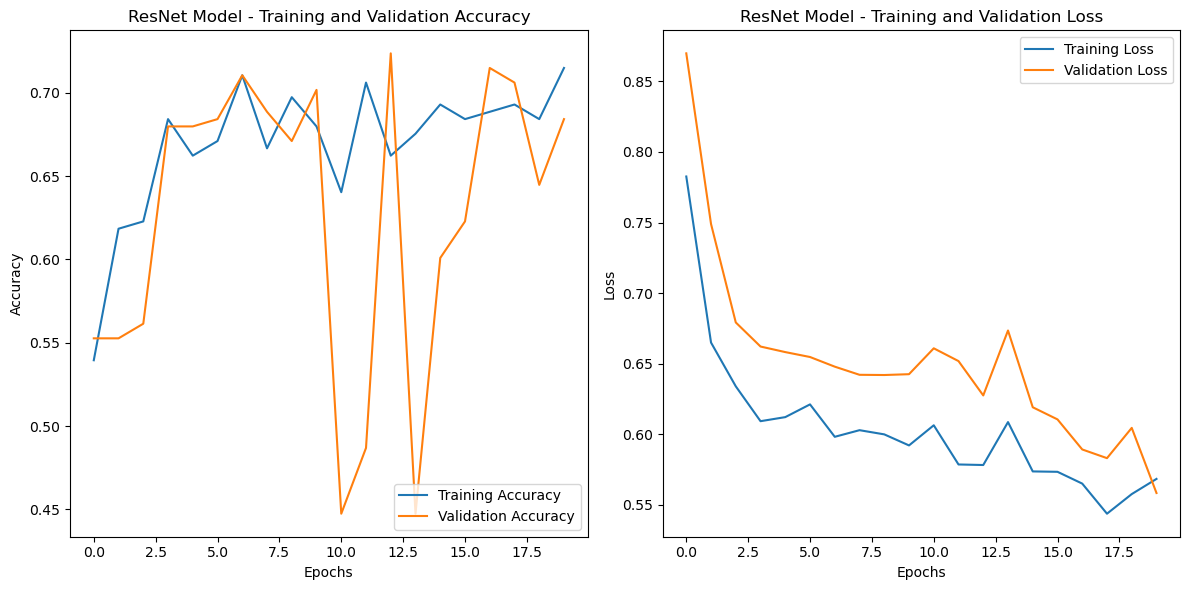

In [29]:
import matplotlib.pyplot as plt

def plot_training_history(history):
   
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('ResNet Model - Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('ResNet Model - Training and Validation Loss')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the function to visualize the results
plot_training_history(final_resnet_history)


In [31]:
#mobilenet

In [33]:
from tensorflow.keras.applications import MobileNetV2

def create_mobilenet_model(hp):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Freeze or unfreeze layers based on hyperparameters
    for layer in base_model.layers[:hp.Int('freeze_layers', min_value=50, max_value=150, step=50)]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)),
        layers.Dense(2, activation='softmax')
    ])

    # Compile the model with a learning rate hyperparameter
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner and perform search for MobileNet
tuner_mobilenet = kt.Hyperband(create_mobilenet_model, 
                               objective='val_accuracy', 
                               max_epochs=10, 
                               hyperband_iterations=2, 
                               directory='mobilenet_tuner', 
                               project_name='monkeypox_mobilenet_tuning')

tuner_mobilenet.search(train_generator, validation_data=valid_generator, epochs=10)



Reloading Tuner from mobilenet_tuner\monkeypox_mobilenet_tuning\tuner0.json


In [35]:

# Retrain Mobilenet model with the best hyperparameters
best_mobilenet_hp = tuner_mobilenet.oracle.get_best_trials()[0].hyperparameters
print("Best MobileNet Hyperparameters: ", best_mobilenet_hp.values)

# Create and train the model with the best hyperparameters
final_mobilenet_model = create_mobilenet_model(best_mobilenet_hp)
final_mobilenet_history = final_mobilenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20
)  # Store the history returned by model.fit()


Best MobileNet Hyperparameters:  {'freeze_layers': 150, 'dense_units': 320, 'dropout_rate': 0.2, 'learning_rate': 0.00040167529976800213, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5352 - loss: 0.7761 - val_accuracy: 0.7895 - val_loss: 0.4671
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7709 - loss: 0.4411 - val_accuracy: 0.8596 - val_loss: 0.3498
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8550 - loss: 0.3028 - val_accuracy: 0.8684 - val_loss: 0.3264
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8663 - loss: 0.3221 - val_accuracy: 0.8904 - val_loss: 0.2671
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8954 - loss: 0.2869 - val_accuracy: 0.9211 - val_loss: 0.2271
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9052 - loss: 0.2398 - val_accuracy: 0.9167 - val_loss: 0.2181
Epoch 7/

In [37]:
# Display the summary of the MobileNet model
final_mobilenet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 320)            │       409,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           642 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,315,272 (16.46 MB)

 Trainable params: 823,362 (3.14 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

 Optimizer params: 1,646,726 (6.28 MB)

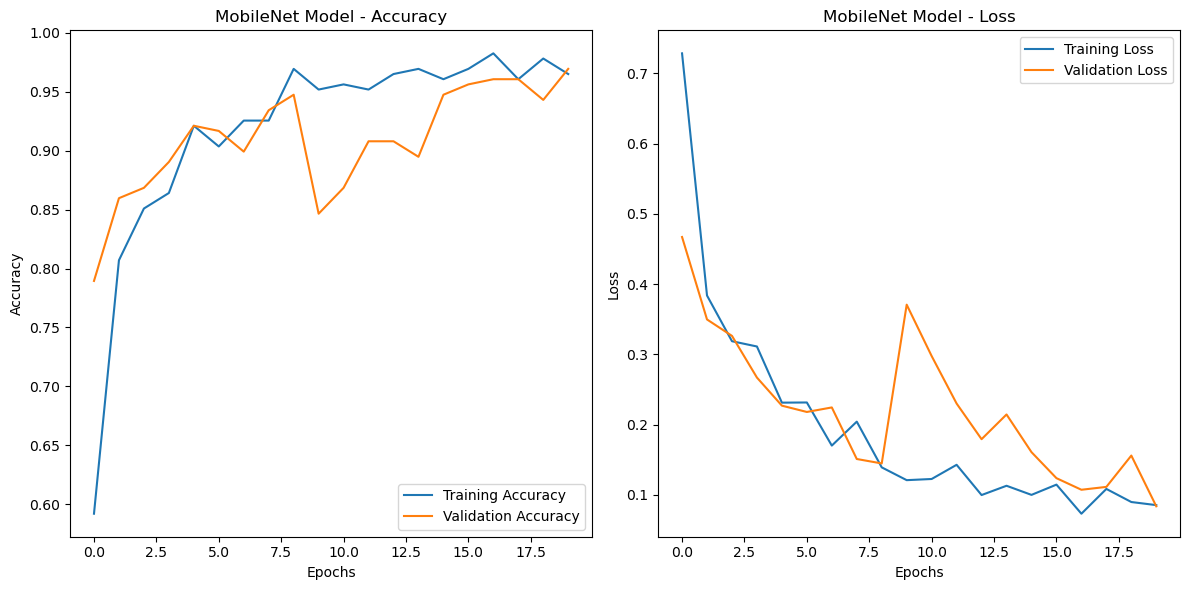

In [39]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy and Loss
def plot_mobilenet_training(history):
    # Create subplots for accuracy and loss
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('MobileNet Model - Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('MobileNet Model - Loss')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_mobilenet_training(final_mobilenet_history)


In [41]:
#Evaluate and Compare Models

In [43]:
cnn_loss, cnn_acc = final_cnn_model.evaluate(valid_generator)
resnet_loss, resnet_acc = final_resnet_model.evaluate(valid_generator)
mobilenet_loss, mobilenet_acc = final_mobilenet_model.evaluate(valid_generator)

print(f"CNN Accuracy: {cnn_acc}, ResNet Accuracy: {resnet_acc}, MobileNet Accuracy: {mobilenet_acc}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 826ms/step - accuracy: 0.6114 - loss: 0.6858
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6933 - loss: 0.5619
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 589ms/step - accuracy: 0.9739 - loss: 0.0691
CNN Accuracy: 0.609649121761322, ResNet Accuracy: 0.6842105388641357, MobileNet Accuracy: 0.969298243522644


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 797ms/step
CNN Model Classification Report:
              precision    recall  f1-score   support

   Monkeypox       0.44      0.62      0.51       102
No_Monkeypox       0.54      0.37      0.44       126

    accuracy                           0.48       228
   macro avg       0.49      0.49      0.48       228
weighted avg       0.50      0.48      0.47       228



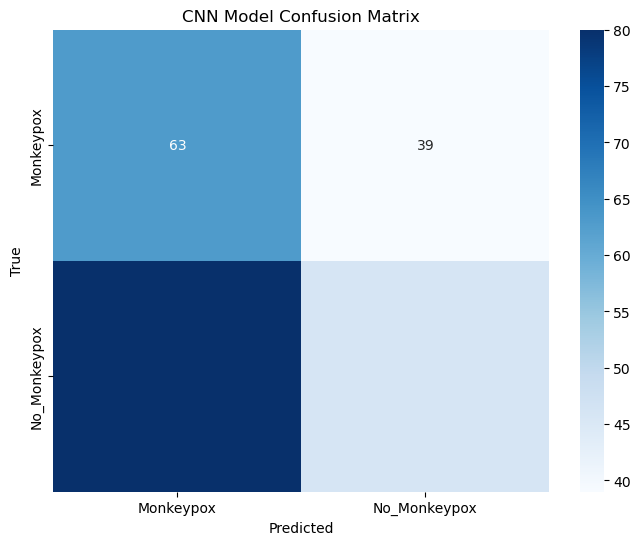

8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step
ResNet Model Classification Report:
              precision    recall  f1-score   support

   Monkeypox       0.47      0.17      0.25       102
No_Monkeypox       0.56      0.85      0.67       126

    accuracy                           0.54       228
   macro avg       0.51      0.51      0.46       228
weighted avg       0.52      0.54      0.48       228



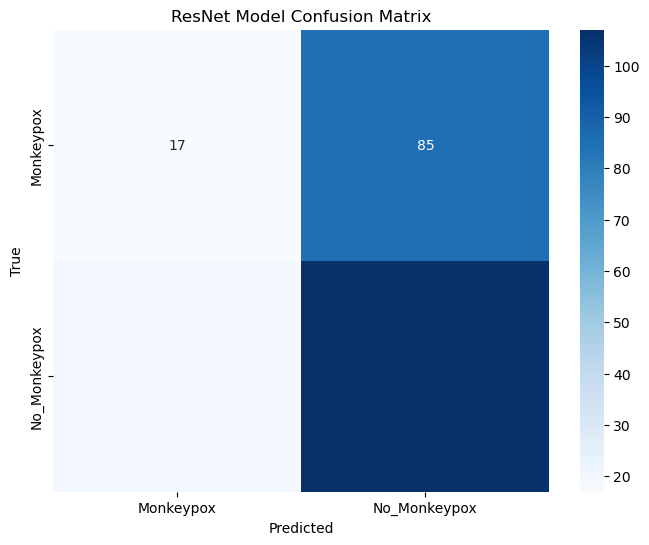

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 977ms/step
MobileNet Model Classification Report:
              precision    recall  f1-score   support

   Monkeypox       0.54      0.55      0.55       102
No_Monkeypox       0.63      0.63      0.63       126

    accuracy                           0.59       228
   macro avg       0.59      0.59      0.59       228
weighted avg       0.59      0.59      0.59       228



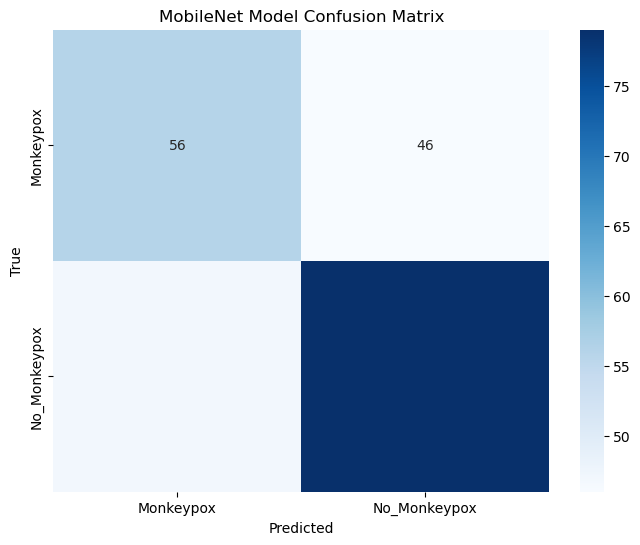

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to evaluate models and display classification report and confusion matrix
def evaluate_model(model, generator, model_name='Model'):
    # Evaluate the model on the validation set
    y_true = generator.classes  # Ground truth labels
    y_pred = model.predict(generator, verbose=1)  # Model predictions

    # Get the predicted class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate classification report
    report = classification_report(y_true, y_pred_labels, target_names=generator.class_indices.keys())
    print(f"{model_name} Classification Report:")
    print(report)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate each model
evaluate_model(final_cnn_model, valid_generator, "CNN Model")
evaluate_model(final_resnet_model, valid_generator, "ResNet Model")
evaluate_model(final_mobilenet_model, valid_generator, "MobileNet Model")


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 787ms/step


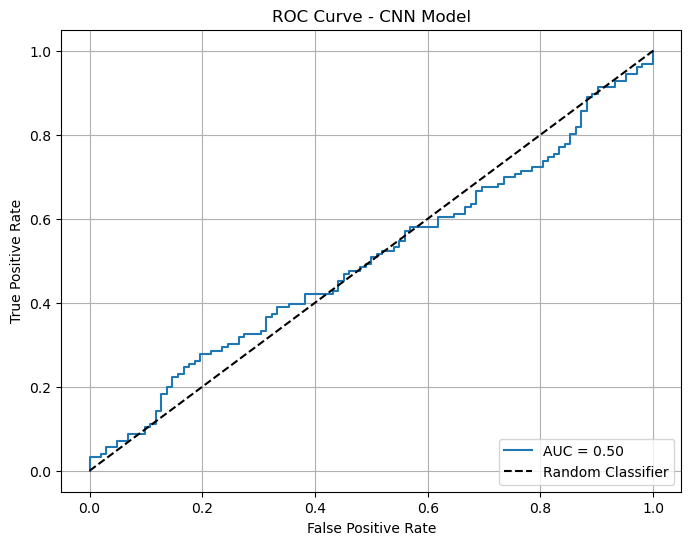

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step


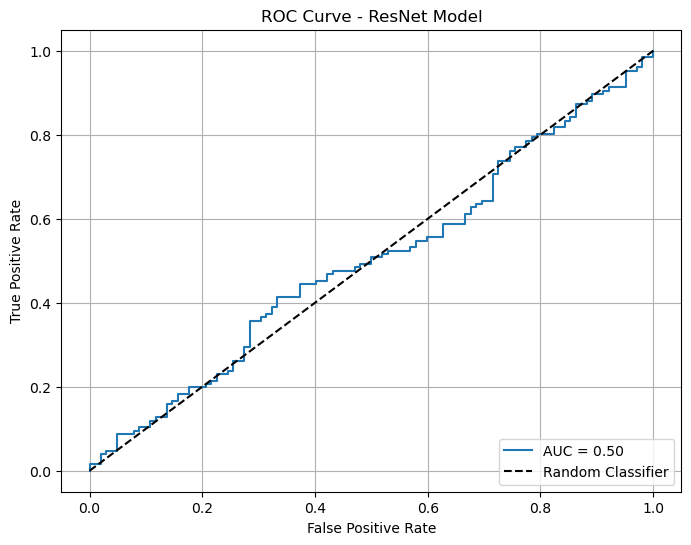

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step


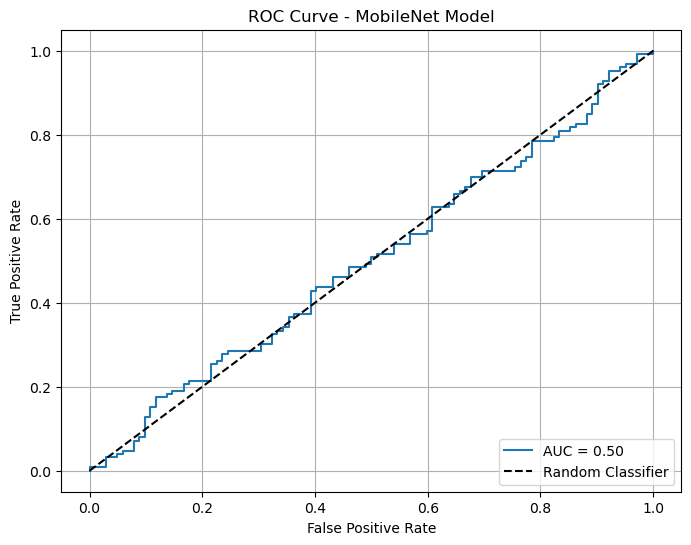

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Function to plot ROC curve for binary classification
def plot_roc_curve_binary(model, generator, model_name="Model"):
    # Get ground truth labels
    y_true = np.array(generator.classes)
    
    # Get predicted probabilities
    y_pred_prob = model.predict(generator, verbose=1).ravel()  # Flatten if binary

    # Ensure consistent lengths by trimming
    min_length = min(len(y_true), len(y_pred_prob))
    y_true = y_true[:min_length]
    y_pred_prob = y_pred_prob[:min_length]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot ROC for each model
plot_roc_curve_binary(final_cnn_model, valid_generator, "CNN Model")
plot_roc_curve_binary(final_resnet_model, valid_generator, "ResNet Model")
plot_roc_curve_binary(final_mobilenet_model, valid_generator, "MobileNet Model")




8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 822ms/step - accuracy: 0.5989 - loss: 0.6870
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7039 - loss: 0.5355
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 583ms/step - accuracy: 0.9599 - loss: 0.0928


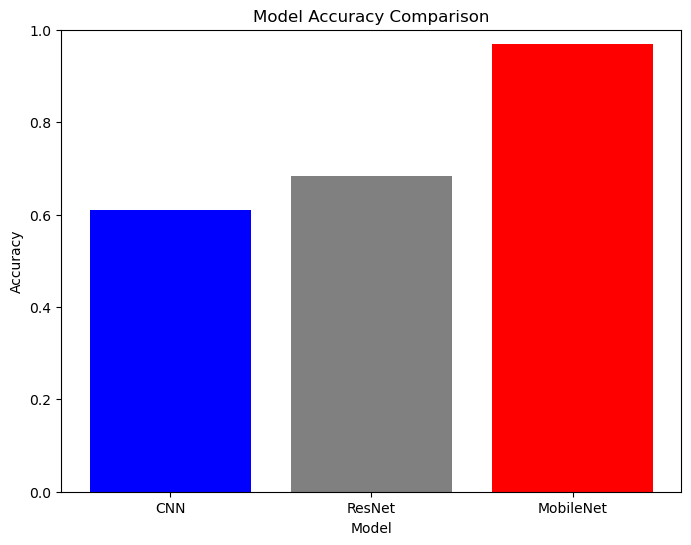

In [61]:
import numpy as np

def plot_accuracy_comparison(models, model_names, valid_generator):
    accuracies = []
    for model in models:
        score = model.evaluate(valid_generator)
        accuracies.append(score[1])  # Accuracy is the second element

    plt.figure(figsize=(8, 6))
    plt.bar(model_names, accuracies, color=['blue', 'grey', 'red'])
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Example usage
models = [final_cnn_model, final_resnet_model, final_mobilenet_model]  # Replace cnn_model with your CNN model
model_names = ['CNN', 'ResNet', 'MobileNet']
plot_accuracy_comparison(models, model_names, valid_generator)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 908ms/step


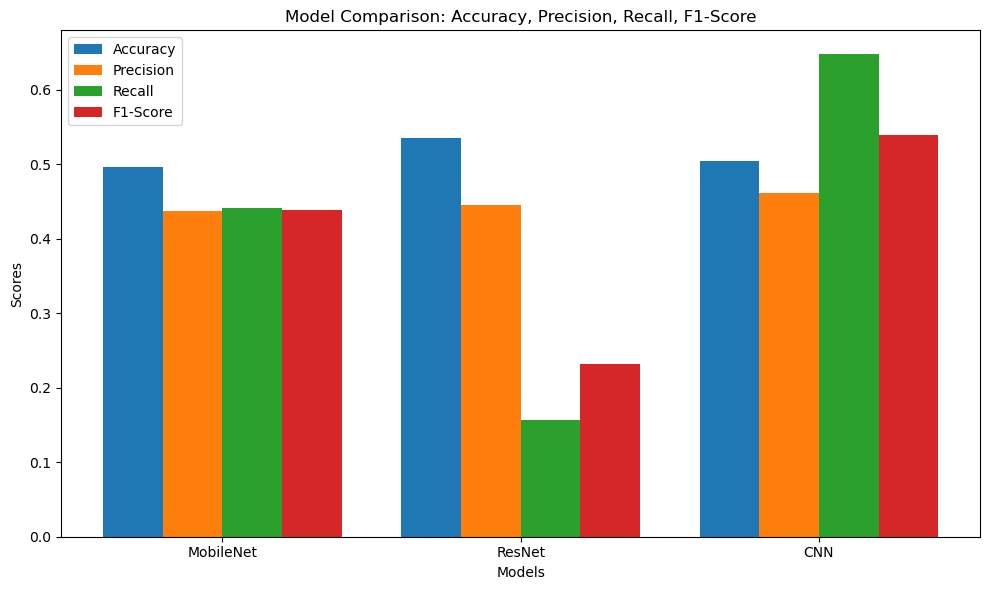

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

def plot_model_comparison(models, model_names, valid_generator):
    # Initialize lists to store metrics
    accuracy = []
    precision = []
    recall = []
    f1_score = []

    # Iterate through each model and calculate the metrics
    for model in models:
        y_true = valid_generator.classes
        y_pred = model.predict(valid_generator, verbose=1)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Get the classification report
        report = classification_report(y_true, y_pred_labels, target_names=valid_generator.class_indices.keys(), output_dict=True)

        # Append metrics to respective lists
        accuracy.append(report['accuracy'])
        precision.append(report['Monkeypox']['precision'])
        recall.append(report['Monkeypox']['recall'])
        f1_score.append(report['Monkeypox']['f1-score'])

    # Set up the positions for the bars
    x = np.arange(len(model_names))
    width = 0.2

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width * 1.5, accuracy, width, label='Accuracy')
    ax.bar(x - width / 2, precision, width, label='Precision')
    ax.bar(x + width / 2, recall, width, label='Recall')
    ax.bar(x + width * 1.5, f1_score, width, label='F1-Score')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1-Score')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
models = [final_mobilenet_model, final_resnet_model, final_cnn_model]  # Replace with your models
model_names = ['MobileNet', 'ResNet', 'CNN']
plot_model_comparison(models, model_names, valid_generator)


In [210]:
import os

# Load your MobileNet model (example)
model = tf.keras.applications.MobileNetV2(weights='imagenet')

# Change the directory to where you want to save the model
os.chdir('D:/MPXProject/mvenv/')

# Save the model to the new directory
final_mobilenet_model.save('mobilenet_model.h5')

# Verify if the model is saved
print(os.listdir())  # List files in the current directory to check


['app.py', 'Include', 'Lib', 'mobilenet_model.h5', 'mobilenet_model.keras', 'monkeypox_data', 'pyvenv.cfg', 'requirements.txt', 'Scripts', 'share', 'static', 'templates']
